In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import math, copy, time
import os
import pandas as pd
import torchinfo

import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

import lstm_encoder_decoder
import data_valuator
import funtions_for_dvrl

import plotting

import json
import pickle

## Import Data 1

In [2]:
x = torch.tensor([2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 18, 17, 15, 14, 12, 11, 9, 8, 6, 5, 3, 2, 0, 1]).view(27,1)
y = torch.tensor([1]).view(1,1)
for i in range(1000):
    y = torch.cat((y,x), dim=0)

for j in range(2):
    y = torch.cat((y,y), dim=1)

y.shape

torch.Size([27001, 4])

In [3]:
dataset2 = y.numpy().astype(np.float64)
print(f"Shape : {dataset2.shape}, Data Type : {dataset2.dtype}")

Shape : (27001, 4), Data Type : float64


<function matplotlib.pyplot.show(close=None, block=None)>

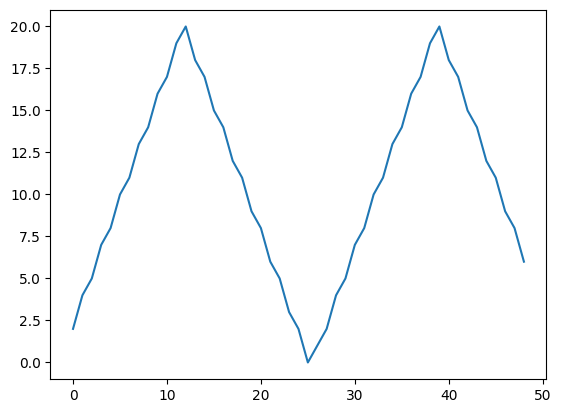

In [4]:
plt.plot(dataset2[1:50,2])
plt.show

## Import Data 2

In [5]:
pre = os.path.dirname(os.path.abspath('__file__'))
post = 'testPuneAQMNew_22.csv'
full_path = os.path.join(pre,post)
df = pd.read_csv(full_path)

In [6]:
print("DataFrame = {} rows {} columns".format(*df.shape))
display(df.head())

DataFrame = 16477 rows 19 columns


,airQualityLevel,observationDateTime,deviceStatus,aqiMajorPollutant,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime
0,VERY_POOR,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,349.0,0.0,0.25,201.40,566.82,305.35,3.67,111.35,21.54,1.24,76.16,4.04,77.90,0.94
1,MODERATE,2022-01-01 00:01:08+05:30,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,103.0,0.0,29.70,2.96,0.00,3.78,3.36,51.81,19.91,4.08,78.80,3.78,77.22,0.94
2,SEVERE,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,408.0,0.0,0.00,328.16,675.62,487.34,3.17,58.84,20.79,1.16,62.37,0.21,77.25,0.94
3,VERY_POOR,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,306.0,0.0,0.00,154.19,73.23,223.55,4.78,68.58,21.54,2.79,77.73,3.62,73.87,0.94
4,VERY_POOR,2022-01-01 00:01:09+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,366.0,0.0,0.00,222.11,315.10,335.07,2.37,64.17,20.91,4.51,75.95,3.13,76.85,0.94


In [7]:
airQualityLevel_dict = {'SATISFACTORY': 1, 'MODERATE': 2, 'POOR': 3, 'VERY_POOR': 4, 'SEVERE': 5}
df['airQualityLevel_encod'] = df.airQualityLevel.map(airQualityLevel_dict)
df = df.drop(['airQualityLevel'], axis=1)
display(df.head())

,observationDateTime,deviceStatus,aqiMajorPollutant,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime,airQualityLevel_encod
0,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,349.0,0.0,0.25,201.40,566.82,305.35,3.67,111.35,21.54,1.24,76.16,4.04,77.90,0.94,4.0
1,2022-01-01 00:01:08+05:30,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,103.0,0.0,29.70,2.96,0.00,3.78,3.36,51.81,19.91,4.08,78.80,3.78,77.22,0.94,2.0
2,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,408.0,0.0,0.00,328.16,675.62,487.34,3.17,58.84,20.79,1.16,62.37,0.21,77.25,0.94,5.0
3,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,306.0,0.0,0.00,154.19,73.23,223.55,4.78,68.58,21.54,2.79,77.73,3.62,73.87,0.94,4.0
4,2022-01-01 00:01:09+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,366.0,0.0,0.00,222.11,315.10,335.07,2.37,64.17,20.91,4.51,75.95,3.13,76.85,0.94,4.0


In [8]:
aqiMajorPollutant_dict = {'PM2.5': 1, 'CO': 2, 'NO2': 3}
df['aqiMajorPollutant_encod'] = df.aqiMajorPollutant.map(aqiMajorPollutant_dict)
df = df.drop(['aqiMajorPollutant'], axis=1)
display(df.head())

,observationDateTime,deviceStatus,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime,airQualityLevel_encod,aqiMajorPollutant_encod
0,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,349.0,0.0,0.25,201.40,566.82,305.35,3.67,111.35,21.54,1.24,76.16,4.04,77.90,0.94,4.0,1.0
1,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,103.0,0.0,29.70,2.96,0.00,3.78,3.36,51.81,19.91,4.08,78.80,3.78,77.22,0.94,2.0,2.0
2,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,408.0,0.0,0.00,328.16,675.62,487.34,3.17,58.84,20.79,1.16,62.37,0.21,77.25,0.94,5.0,1.0
3,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,306.0,0.0,0.00,154.19,73.23,223.55,4.78,68.58,21.54,2.79,77.73,3.62,73.87,0.94,4.0,1.0
4,2022-01-01 00:01:09+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,366.0,0.0,0.00,222.11,315.10,335.07,2.37,64.17,20.91,4.51,75.95,3.13,76.85,0.94,4.0,1.0


In [9]:
features_considered = ['airQualityLevel_encod', 'aqiMajorPollutant_encod','airQualityIndex','uv.avgOverTime',
                       'o3.avgOverTime','pm2p5.avgOverTime','co2.avgOverTime','pm10.avgOverTime','co.avgOverTime','no2.avgOverTime',
                       'airTemperature.avgOverTime','illuminance.avgOverTime','ambientNoise.avgOverTime','so2.avgOverTime',
                       'relativeHumidity.avgOverTime','atmosphericPressure.avgOverTime']
features = df[features_considered]
features.index = df['observationDateTime']

In [10]:
dataset1 = features.values
print(f"Shape : {dataset1.shape}, Data Type : {dataset1.dtype}")

Shape : (16477, 16), Data Type : float64


## Corrupt Data

<function matplotlib.pyplot.show(close=None, block=None)>

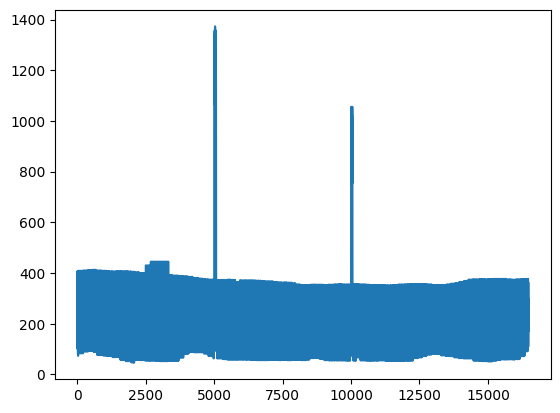

In [11]:
dataset1[5000:5070] += 1000
dataset1[10000:10050] += 700
plt.plot(dataset1[:,2])
plt.show

## Convert Data Shape

In [12]:
train_split = 14000
lookback = 5
lookahead = 2
step = 1
batch_size = 45

x_train_multi, y_train_multi = funtions_for_dvrl.multivariate_data(dataset1, dataset1, 0,
                                                 train_split, lookback,
                                                 lookahead, step)
x_val_multi, y_val_multi = funtions_for_dvrl.multivariate_data(dataset1, dataset1,
                                             train_split, 15000, lookback,
                                             lookahead, step)

print (
       'Train Dataset X Size : {}'.format(x_train_multi.shape),
       'Train Dataset Y Size : {}'.format(y_train_multi.shape),
       'Validation Dataset X Size : {}'.format(x_val_multi.shape),
       'Validation Dataset Y Size : {}'.format(y_val_multi.shape),
       sep='\n')

Train Dataset X Size : (13995, 5, 16)
Train Dataset Y Size : (13995, 2, 16)
Validation Dataset X Size : (995, 5, 16)
Validation Dataset Y Size : (995, 2, 16)


In [13]:
#Extracting a single column for univariante time series
x_train = torch.from_numpy(x_train_multi[:,:,2])
y_train = torch.from_numpy(y_train_multi[:,:,2])
x_valid = torch.from_numpy(x_val_multi[1:100,:,2])
y_valid = torch.from_numpy(y_val_multi[1:100,:,2])

x_valid = torch.unsqueeze(x_valid,2)
x_valid = x_valid.transpose(1,0).float()

y_valid = torch.unsqueeze(y_valid,2)
y_valid = y_valid.transpose(1,0).float()
print(f"X Train Shape : {x_train.shape}")
print(f"Y Train Shape : {y_train.shape}")
print(f"X Valid Shape : {x_valid.shape}")
print(f"Y Valid Shape : {y_valid.shape}")

X Train Shape : torch.Size([13995, 5])
Y Train Shape : torch.Size([13995, 2])
X Valid Shape : torch.Size([5, 99, 1])
Y Valid Shape : torch.Size([2, 99, 1])


In [14]:
g = torch.Generator().manual_seed(2147483647)

## Make Model

In [15]:
def make_model(lookback = lookback, lookahead = lookahead, datavaluator_hidden = 64):
    "Helper: Construct a model from hyperparameters."
    #c = copy.deepcopy
    #data_valuator_mlp = Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    model_1 = data_valuator.Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    return model_1

In [16]:
model_1 = make_model()
moving_avg_loss = 0
criterion = nn.MSELoss()

In [17]:
torchinfo.summary(model_1, [(batch_size, lookback + lookahead)], dtypes=[torch.float64, torch.float64], col_names=["input_size", "output_size", 
                                                                                                 "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Data_Valuator_MLP                        [45, 7]                   [45, 1]                   --                        True
├─Sequential: 1-1                        [45, 7]                   [45, 1]                   --                        True
│    └─Linear: 2-1                       [45, 7]                   [45, 64]                  512                       True
│    └─ReLU: 2-2                         [45, 64]                  [45, 64]                  --                        --
│    └─Linear: 2-3                       [45, 64]                  [45, 128]                 8,320                     True
│    └─ReLU: 2-4                         [45, 128]                 [45, 128]                 --                        --
│    └─Linear: 2-5                       [45, 128]                 [45, 64]                  8,256                     True
│    └─

## Model Config File

In [18]:
config = {
    "alpha" : {
        'values' : [0.1, 0.5, 2, 5]
    },
    "learning_rate" : {
        'values' : [0.01, 0.1]
    },
    "hidden_size" : {
        'values' : [32, 64],
    },
    "epochs" : {
        'values' : [3,5],
}

with open("config.json", "w") as outfile: 
    json.dump(config, outfile)

SyntaxError: '{' was never closed (1768936063.py, line 1)

In [ ]:
with open("config.json", 'r') as json_file:
    config = json.load(json_file)

print(config)

In [ ]:
sweep_config = {
    'method' : 'random'
}

sweep_config['parameters'] = config

In [ ]:
import pprint

pprint.pprint(sweep_config)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="dvrl-time-series")

## Train Model

In [28]:
for p in model_1.parameters():
    p.requires_grad = True #False

alpha = 20
learning_rate = 0.001
time_window_size = 45
reward = -10
mov_avg_plot = []
reward_plot = []
val_loss_plot = []
iteration = []
mean_of_hidden = []

In [ ]:
## MLP MODEL

reward = 0
model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 32)
num_of_epochs = 4
iter = 0
for i in range(num_of_epochs):
    for T in range(12000):
        
        #Make Time Window Batches
        if T == 12000:
            break
        x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
        #Pass Throught Data Valuator MLP
        input = torch.cat((x_batch,y_batch), 1)
        prob_vector = model_1.forward(input)
        select = data_valuator.SelectionFromProb(prob_vector, g)
        select_for_lstm = select.clone().detach()
        x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
        if torch.all(select==0).item():
            continue
        #Reshape For LSTM
        x_selected_batch = torch.unsqueeze(x_selected_batch,2)
        x_selected_batch = x_selected_batch.transpose(1,0).float()
        y_selected_batch = torch.unsqueeze(y_selected_batch,2)
        y_selected_batch = y_selected_batch.transpose(1,0).float()
        #Pass Through LSTM
        loss = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
                             training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.6, learning_rate = learning_rate, dynamic_tf = False)
        curr_lossi = lstm_encoder_decoder.predict_loss(model_4, x_valid, y_valid)
        curr_loss = torch.tensor(curr_lossi)
        #Update The Moving Average
        moving_avg_loss = funtions_for_dvrl.MAL(curr_loss, T+1, moving_avg_loss)
        #Determine The Log_Pi Loss And Reward Scale
        reward = curr_loss - moving_avg_loss
        data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi(select, prob_vector)
        if torch.eq(reward,0).item():
            reward = torch.tensor(-1)
        #Update The Data Valuator Parameters
        reward_for_data = reward.clone().detach()
        mov_avg_plot.append(moving_avg_loss)
        reward_plot.append(reward)
        curr_loss_plot.append(curr_loss)
        iteration.append(iter)
        iter+=1
        if T%1000 == 0:
            print(f"curr_loss = {curr_loss}, mov_avg = {moving_avg_loss}, reward = {reward}")
        if i == 0:
            continue
        data_valuator.Data_Valuator_Train(model_1, data_valuator_loss, -reward_for_data, alpha)

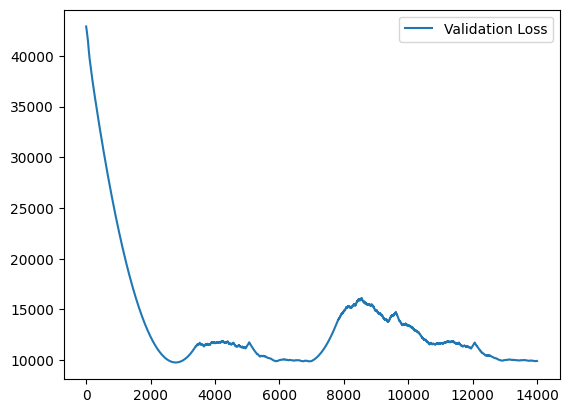

In [21]:
val_plot_list = [tensor for tensor in val_loss_plot]
reward_plot_list = [tensor for tensor in reward_plot]
mov_avg_plot_list = [tensor for tensor in mov_avg_plot]
mean_of_hidden_list = [tensor for tensor in mean_of_hidden]
iteration_plot_list = iteration
plt.plot(iteration, val_plot_list, label='Validation Loss')
#plt.plot(iteration, mov_avg_plot_list, label='Moving Avg Loss')
#plt.xlim(10000, 11000)
#plt.ylim(10100, 10250)
#plt.plot(iteration, x_train[0:800,2], label='Dataset')
plt.legend()
plt.show()

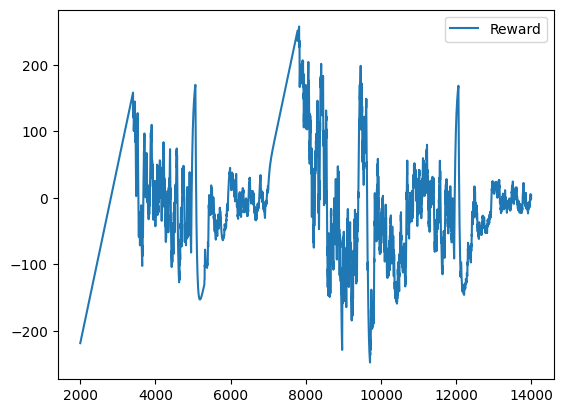

In [22]:
plt.plot(iteration[2000:], reward_plot_list[2000:], label='Reward')
plt.legend()
plt.show()

In [23]:
mee = []
for i in range(len(mean_of_hidden_list)):
    mee.append(mean_of_hidden_list[i].clone().detach())

In [24]:
meean_of_hidden_list = [tensor for tensor in mee]

In [ ]:
iteration.append(395)

In [ ]:
mean_of_hidden_list[0:146]

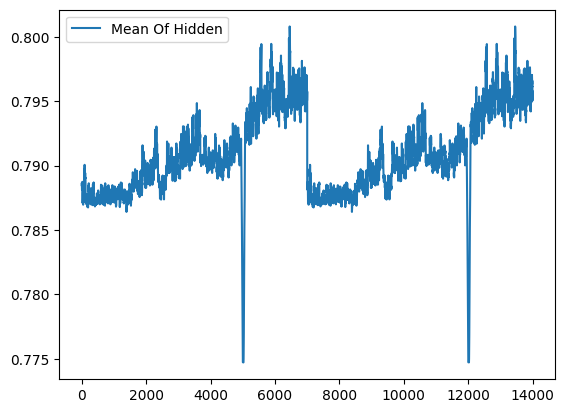

In [25]:
plt.plot(iteration, meean_of_hidden_list, label='Mean Of Hidden')
plt.legend()
plt.show()

In [27]:
torch.save({
            'num_of_epochs': num_of_epochs,
            'model_state_dict': model_5.state_dict(),
            'final_reward': reward
            }, 'C:/Users/poops/Desktop/Coding Shenanigans/RnDProject/plswork/data_valuator.pth')

In [ ]:
asymtote = 0

In [ ]:
# ## HMM MODEL

# reward = 0
# model_5 = data_valuator.Data_Valuator_LSTM(input_size = 1, hidden_size = 32, 5)
# model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 64)
# num_of_epochs = 4
# iter = 0
# for i in range(num_of_epochs):
#     moving_avg_loss = 0
#     for T in range(23000):
        
#         #Make Time Window Batches
#         if T == 23000:
#             break
#         x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
#         #Pass Throught Data Valuator MLP
#         x_batch_reshape = torch.unsqueeze(x_batch, 2)
#         x_batch_reshape = x_batch_reshape.transpose(1,0).float()
#         encoder_hidden = model_5.init_hidden()
#         encoder_output, encoder_hidden = model_5(x_batch_reshape)
#         prob_vector = encoder_hidden.view(x_batch.shape[0],1)
#         if i == 0:
#             prob_vector = torch.ones(x_batch.shape[0],1)
#         select = data_valuator.SelectionFromProb(prob_vector, g)
#         select_for_lstm = select.clone().detach()
#         x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
#         if torch.all(select==0).item():
#             continue
#         #Reshape For LSTM
#         x_selected_batch = torch.unsqueeze(x_selected_batch,2)
#         x_selected_batch = x_selected_batch.transpose(1,0).float()
#         y_selected_batch = torch.unsqueeze(y_selected_batch,2)
#         y_selected_batch = y_selected_batch.transpose(1,0).float()
#         #Pass Through LSTM
#         loss = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
#                              training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.2, learning_rate = learning_rate, dynamic_tf = False)
#         curr_lossi = lstm_encoder_decoder.predict_loss(model_4, x_valid, y_valid)
#         val_loss = torch.tensor(curr_lossi)
#         #Update The Moving Average
#         moving_avg_loss = funtions_for_dvrl.MAL(val_loss, T+1, moving_avg_loss)
#         reward = funtions_for_dvrl.HMM(val_loss, T+1, asymtote)
#         #Determine The Log_Pi Loss And Reward Scale
#         #reward = val_loss - moving_avg_loss
#         data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi(select, prob_vector)
#         if torch.eq(reward,0).item():
#             reward = torch.tensor(-1)
#         #Update The Data Valuator Parameters
#         reward_for_data = reward.clone().detach()
#         mov_avg_plot.append(moving_avg_loss)
#         if i == 0 :
#             reward_for_data = 0
#         reward_plot.append(reward_for_data)
#         val_loss_plot.append(val_loss)
#         iteration.append(iter)
#         iter+=1
#         if T%1000 == 0:
#             print(f"val_loss = {val_loss}, mov_avg = {moving_avg_loss}, reward = {reward_for_data}")
#         if i == 0:
#             asymtote = moving_avg_loss/2
#             continue
#         data_valuator.Data_Valuator_Train(model_5, data_valuator_loss, reward_for_data, alpha)

In [ ]:
## INCREASED HIDDEN SIZE MODEL + IIR

reward = 0
model_5 = data_valuator.Data_Valuator_LSTM(input_size = 1, hidden_size = 32, batch_size = 45)
model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 64)
num_of_epochs = 10
iter = 0
moving_avg_loss = 0
reward = 0
beta = 0.03
for i in range(num_of_epochs):
    for T in range(7000):
        
        #Make Time Window Batches
        if T == 7000:
            break
        x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
        #Pass Throught Data Valuator MLP
        x_batch_reshape = torch.unsqueeze(x_batch, 2)
        x_batch_reshape = x_batch_reshape.transpose(1,0).float()
        #print(x_batch_reshape.shape)
        intialized_hidden = model_5.init_hidden()
        encoder_hidden, hid = model_5(x_batch_reshape, intialized_hidden)
        #print(encoder_hidden.shape)
        #print(encoder_hidden)
        prob_vector = encoder_hidden.view(x_batch.shape[0],1)
        mean = torch.mean(prob_vector).clone().detach()
        #print(torch.mean(prob_vector).clone().detach())
        mean_of_hidden.append(torch.mean(prob_vector).clone().detach())
        if i == 0:
            prob_vector = torch.ones(x_batch.shape[0],1)
        select = data_valuator.SelectionFromProb(prob_vector, g)
        #print(prob_vector.shape)
        #print(prob_vector)
        #print(select.shape)
        if T % 1000 == 0:
            print(mean)
            print(hid) # hid is the inside of linear layer in sigmoid
            print(prob_vector)
        select_for_lstm = select.clone().detach()
        x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
        if torch.all(select==0).item():
            continue
        #Reshape For LSTM
        x_selected_batch = torch.unsqueeze(x_selected_batch,2)
        x_selected_batch = x_selected_batch.transpose(1,0).float()
        y_selected_batch = torch.unsqueeze(y_selected_batch,2)
        y_selected_batch = y_selected_batch.transpose(1,0).float()
        #Pass Through LSTM
        loss = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
                             training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.2, learning_rate = learning_rate, dynamic_tf = False)
        curr_lossi = lstm_encoder_decoder.predict_loss(model_4, x_valid, y_valid)
        val_loss = torch.tensor(curr_lossi)
        #Update The Moving Average
        moving_avg_loss = funtions_for_dvrl.IIR(val_loss, iter+1, moving_avg_loss, beta)
        #Determine The Log_Pi Loss And Reward Scale
        reward = val_loss - moving_avg_loss
        data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi(select, prob_vector)
        if torch.eq(reward,0).item():
            reward = torch.tensor(-1)
        #Update The Data Valuator Parameters
        reward_for_data = reward.clone().detach()
        mov_avg_plot.append(moving_avg_loss)
        reward_plot.append(reward_for_data)
        val_loss_plot.append(val_loss)
        iteration.append(iter)
        iter+=1
        if T%1000 == 0:
            print(f"val_loss = {val_loss}, mov_avg = {moving_avg_loss}, reward = {reward_for_data}")
        if i == 0:
            continue
        if T%1000 == 0:
            print("skip")
        data_valuator.Data_Valuator_Train(model_5, data_valuator_loss, -reward_for_data, alpha)

weight_ih_l0 torch.Size([128, 1]) Orthogonal
weight_hh_l0 torch.Size([128, 32]) torch.Size([128, 32]) 32 Identity
bias_ih_l0 torch.Size([128]) Zeros
bias_hh_l0 torch.Size([128]) Zeros
bias torch.Size([1]) Zeros
lstm.weight_ih_l0 torch.Size([128, 1]) Orthogonal
lstm.weight_hh_l0 torch.Size([128, 32]) torch.Size([128, 32]) 32 Identity
lstm.bias_ih_l0 torch.Size([128]) Zeros
lstm.bias_hh_l0 torch.Size([128]) Zeros
linear.bias torch.Size([1]) Zeros
tensor(0.8509)
tensor([[1.6861],
        [1.7629],
        [1.7978],
        [1.7660],
        [1.7233],
        [1.8091],
        [1.7445],
        [1.7017],
        [1.7867],
        [1.7124],
        [1.6906],
        [1.6884],
        [1.7062],
        [1.6828],
        [1.6905],
        [1.6964],
        [1.7927],
        [1.7849],
        [1.8129],
        [1.7254],
        [1.8210],
        [1.8411],
        [1.7310],
        [1.7069],
        [1.6940],
        [1.7921],
        [1.6972],
        [1.6824],
        [1.6885],
        [1.786